# **1. Import library**

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import json
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess

# **2. Load Dataset**

In [2]:
df = pd.read_csv('CBF.csv')

# **3. Data Wrangling**

## 3.1. Statistics Descriptive

In [3]:
# Ringkasan data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     295 non-null    int64  
 1   nama_tempat    295 non-null    object 
 2   rating         292 non-null    float64
 3   jumlah_ulasan  292 non-null    float64
 4   alamat         295 non-null    object 
 5   link           295 non-null    object 
 6   thumbnail      294 non-null    object 
 7   kategori       295 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 18.6+ KB


In [4]:
df.describe()

,Unnamed: 0,rating,jumlah_ulasan
count,295.00000,292.000000,292.000000
mean,147.00000,4.400000,1487.825342
std,85.30338,0.265806,2957.632440
min,0.00000,3.000000,1.000000
25%,73.50000,4.300000,132.500000
50%,147.00000,4.400000,440.000000
75%,220.50000,4.600000,1339.000000
max,294.00000,5.000000,24427.000000


## 3.2. Handling Missing Value

In [5]:
# Hapus baris dengan thumbnail kosong karena gambar penting untuk ditampilkan
df = df.dropna(subset=['rating', 'jumlah_ulasan', 'thumbnail'])

# Pastikan kolom numerik tidak ada NaN
df[['rating', 'jumlah_ulasan']] = df[['rating', 'jumlah_ulasan']].fillna(0)

# Buat kolom gabungan konten
df['content'] = df['nama_tempat'] + ' ' + df['kategori'] + ' ' + df['alamat']

<ipython-input-5-b08f8c14d950>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['rating', 'jumlah_ulasan']] = df[['rating', 'jumlah_ulasan']].fillna(0)
<ipython-input-5-b08f8c14d950>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['nama_tempat'] + ' ' + df['kategori'] + ' ' + df['alamat']


# **4. Exploratory Data Analysis (EDA)**

## 4.1. Distribusi Rating

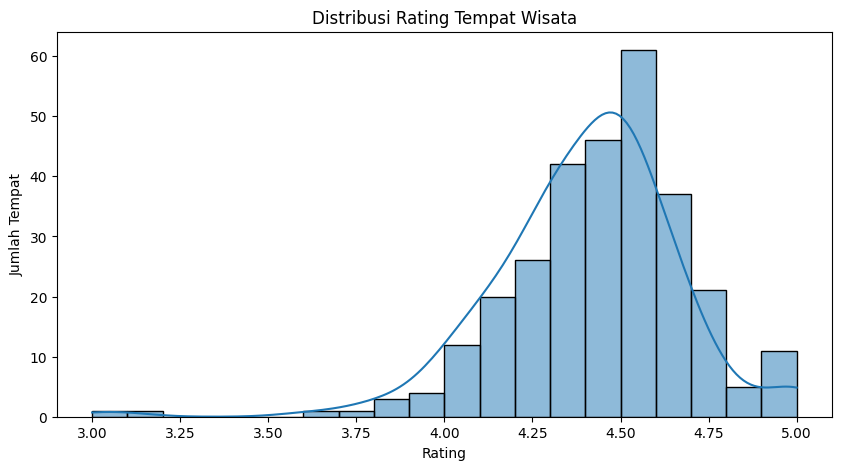

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribusi Rating Tempat Wisata')
plt.xlabel('Rating')
plt.ylabel('Jumlah Tempat')
plt.show()

## 4.2. Boxplot Jumlah Ulasan


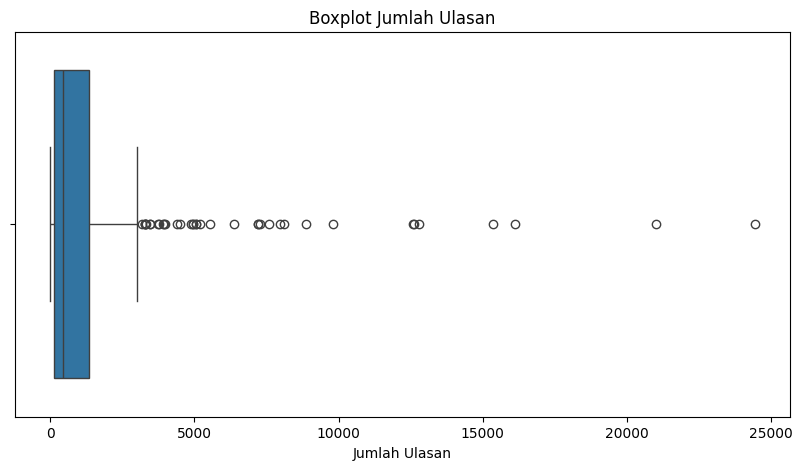

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['jumlah_ulasan'])
plt.title('Boxplot Jumlah Ulasan')
plt.xlabel('Jumlah Ulasan')
plt.show()

## 4.3. Korelasi antar fitur numerik

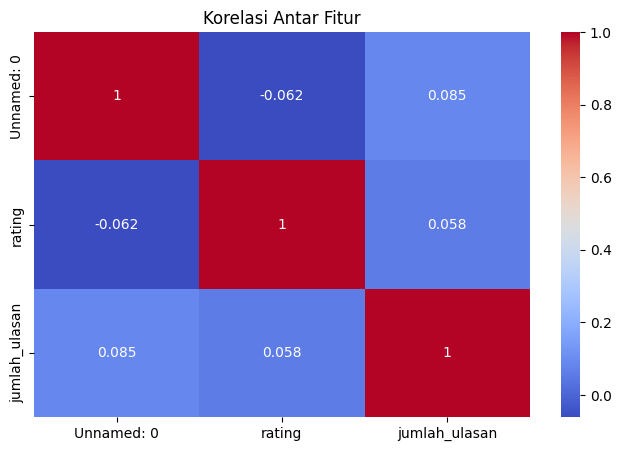

In [8]:
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur')
plt.show()

# **5. Preprocessing**

In [9]:
# 5.1 TF-IDF + Dimensionality Reduction
from sklearn.feature_extraction import text
# Buat list stop-words bahasa Inggris + beberapa kata umum Bahasa Indonesia
id_stop = list(text.ENGLISH_STOP_WORDS) + ['yang', 'di', 'ke', 'dari']

tfidf = TfidfVectorizer(
    stop_words=id_stop,    # sekarang list, bukan frozenset
    max_df=0.8,
    ngram_range=(1,2)
)
X_tfidf = tfidf.fit_transform(df['content'])
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

scaler = MinMaxScaler()
X_num = scaler.fit_transform(df[['rating', 'jumlah_ulasan']])

alpha, beta = 0.5, 2.0
X_combined = np.hstack([X_svd * alpha, X_num * beta])
print(f"Combined feature shape: {X_combined.shape}")

Combined feature shape: (292, 102)


# **6. Bangun Model**

In [10]:
input_dim = X_combined.shape[1]
inputs = layers.Input(shape=(input_dim,))

# Encoder
x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5))(inputs)
x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5))(x)
embedding = layers.Dense(16, activation=None, name='embedding')(x)

# Decoder
x = layers.Dense(32, activation='relu')(embedding)
x = layers.Dense(64, activation='relu')(x)
# Use linear activation on output
output_layer = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inputs, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 102)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 102)            │         6,630 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,486 (72.21 KB)

 Trainable params: 18,486 (72.21 KB)

 Non-trainable params: 0 (0.00 B)

# **7. Latih Model**

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
history = autoencoder.fit(
    X_combined, X_combined,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/100
8/8 - 6s - 729ms/step - loss: 0.0234 - val_loss: 0.0187
Epoch 2/100
8/8 - 2s - 255ms/step - loss: 0.0203 - val_loss: 0.0153
Epoch 3/100
8/8 - 1s - 68ms/step - loss: 0.0155 - val_loss: 0.0098
Epoch 4/100
8/8 - 1s - 68ms/step - loss: 0.0088 - val_loss: 0.0043
Epoch 5/100
8/8 - 1s - 65ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 6/100
8/8 - 0s - 35ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 7/100
8/8 - 0s - 28ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 8/100
8/8 - 0s - 37ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/100
8/8 - 0s - 26ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 10/100
8/8 - 0s - 17ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 11/100
8/8 - 0s - 18ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 12/100
8/8 - 0s - 17ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 13/100
8/8 - 0s - 17ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 14/100
8/8 - 0s - 18ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 15/100
8/8 - 0s - 17ms/step - loss: 0.0027 - val_

# **8. Evaluasi**

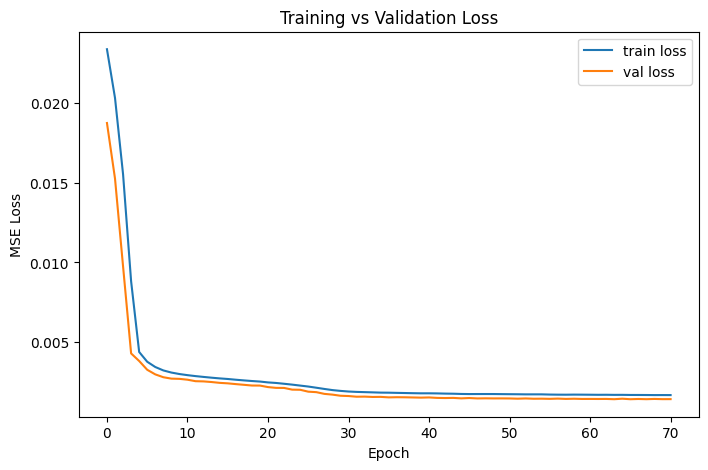

In [12]:
# Plot Loss Curve
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


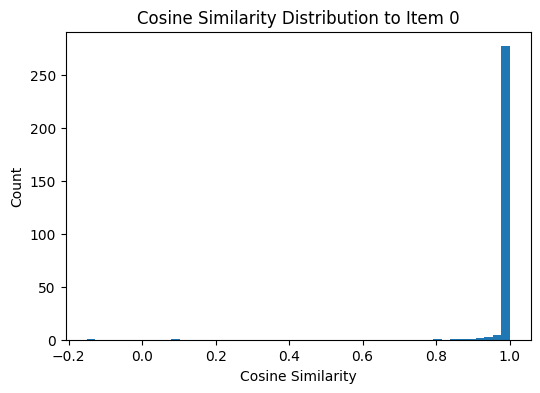

Min, Max, Mean: -0.15069684 1.0 0.9830633


In [13]:
def plot_histogram(sim_values, title):
    plt.figure(figsize=(6,4))
    plt.hist(sim_values, bins=50)
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Count')
    plt.show()

encoder = models.Model(inputs=autoencoder.input,
                        outputs=autoencoder.get_layer('embedding').output)
emb = encoder.predict(X_combined)
# L2 normalization
emb_norm = emb / np.linalg.norm(emb, axis=1, keepdims=True)
# Example similarity for item idx 0
dist0 = emb_norm @ emb_norm[0]
plot_histogram(dist0, 'Cosine Similarity Distribution to Item 0')
print("Min, Max, Mean:", dist0.min(), dist0.max(), dist0.mean())

# **9. Inference**


In [14]:
cosine_sim = emb_norm.dot(emb_norm.T)

def recommend(idx, top_k=5):
    sim_scores = cosine_sim[idx]
    top_idx = np.argsort(-sim_scores)
    results, seen = [], set()
    for i in top_idx:
        name = df['nama_tempat'].iloc[i]
        if name in seen: continue
        seen.add(name)
        results.append((name, df['rating'].iloc[i], sim_scores[i]))
        if len(results) >= top_k: break
    return results

# Print Top-5 for idx 0
recos = recommend(0, top_k=5)
print("Top-5 Recommendations:")
for i,(n,r,s) in enumerate(recos,1):
    print(f"{i}. {n} – Rating {r:.2f} – CosineSim {s:.4f}")

Top-5 Recommendations:
1. Wisata Alam Datuk – Rating 3.90 – CosineSim 1.0000
2. Sawah Lukis – Rating 3.90 – CosineSim 0.9987
3. Pondok Surya – Rating 4.10 – CosineSim 0.9982
4. Hasnah Kuliner – Rating 3.80 – CosineSim 0.9982
5. Pondok Naga Pantai Galau – Rating 3.80 – CosineSim 0.9981


# **10. Simpan Model**

## Saved Model

In [15]:
!pip install tensorflowjs

# Simpan model encoder
if not os.path.exists("model"):
    os.makedirs("model")

# 10.1 Save TensorFlow SavedModel for TFJS conversion
encoder.export('model/cbf_encoder_savedmodel', save_format='tf')

# 10.2 Save Keras H5/TF models
encoder.save('model/cbf_encoder.keras', save_format='tf')
autoencoder.save('model/cbf_autoencoder.keras', save_format='tf')

# 10.3 Convert to TensorFlowJS format (ensure tensorflowjs is installed)
try:
    subprocess.run([
        'tensorflowjs_converter',
        '--input_format=tf_saved_model',
        '--output_format=tfjs_graph_model',
        'model/cbf_encoder_savedmodel',
        'model/tfjs_model'
    ], check=True)
except Exception as e:
    print("TFJS conversion failed:", e)

# 10.4 Save item features and ratings to numpy & JSON
np.save('model/item_features.npy', X_combined)
np.save('model/place_ratings.npy', df['rating'].values)
with open('model/item_features.json', 'w') as f:
    json.dump(X_combined.tolist(), f)
with open('model/place_ratings.json', 'w') as f:
    json.dump(df['rating'].tolist(), f)
with open('model/place_names.json', 'w') as f:
    json.dump(df['nama_tempat'].tolist(), f)

!pip freeze > model/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
Saved artifact at 'model/cbf_encoder_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 102), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)
Captures:
  13278870694216

In [16]:
import shutil

# Zip folder model menjadi cbf_encoder.zip
shutil.make_archive('model_cbf', 'zip', 'model')

from google.colab import files
files.download('model_cbf.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>